In [1]:
import awkward as ak
import uproot
import vector
import matplotlib.pyplot as plt

In [2]:
schema = {
    "Electrons": [
        "pt", "eta", "phi", "m"
    ],
    "Muons": [
        "pt", "eta", "phi",
    ],
    "Jets": [
        "pt", "eta", "phi", "m"
    ],
    "BTagging_AntiKt4EMPFlow": [
        "DL1dv01_pb",
    ]
}

In [3]:
def from_root(filename, **kwargs):
    with uproot.open(filename, **kwargs) as f:
        tree = f["CollectionTree"]
        events = {}
        for objname, fields in schema.items():
            base = objname
            if objname in ["Electrons", "Muons", "Jets"]:
                base = "Analysis" + objname
            arrays = tree.arrays(
                fields,
                aliases={field: f"{base}AuxDyn.{field}" for field in fields},
            )
            arrays = ak.zip(dict(zip(arrays.fields, ak.unzip(arrays))))
            events[objname] = arrays
        return ak.zip(events, depth_limit=1)

In [4]:
%run rucio_utils.py

In [5]:
%run fsspec_source.py

In [6]:
class RucioFileGCPSource(FSSpecHttpSource):
    def __init__(self, file_path, **kwargs):
        scope, name = file_path.split(".", maxsplit=1) # take filename in "{scope}.{name}" format
        url = get_signed_url(scope, name, rse=rse)
        super().__init__(url, **kwargs)

In [7]:
with open("x509", "rb") as f:
    x509_data = f.read()
setup_rucio_and_proxy(x509_data, rucio_account="nihartma")

In [8]:
rse = "GOOGLE-EU_DATADISK"
scope = "mc21_13p6TeV"
filename = "DAOD_PHYSLITE.33080408._000001.pool.root.1"

In [10]:
events = from_root(f"{scope}.{filename}", file_handler=RucioFileGCPSource)

In [11]:
events

<Array [{Electrons: [{...}], ...}, ..., {...}] type='20000 * {Electrons: va...'>

In [12]:
events.Electrons.pt

<Array [[5.92e+03], [], [1.46e+05], ..., [], []] type='20000 * var * float32'>

In [13]:
GeV = 1000.

In [14]:
# Note: this code is exactly the same as for the `dask_awkward` case

def electron_selection(el):
    return (el.pt > 30 * GeV) & (abs(el.eta) < 2.47)

def muon_selection(mu):
    return (mu.pt > 30 * GeV) & (abs(mu.eta) < 2.47)

def jet_selection(j):
    return (j.pt > 30 * GeV) & (abs(j.eta) < 2.47)

def selection(events):
    #events = copy.copy(events) # make shallow copy - needs https://github.com/dask-contrib/dask-awkward/pull/324
    events = ak.with_field(events, events.Jets, "Jets") # workaround

    # TODO: overlap removal

    # decorations
    events["Jets", "btagging"] = events.BTagging_AntiKt4EMPFlow # technically this is an ElementLink, but seems in PHYSLITE exactcly one link for each jet
    events["Jets", "is_bjet"] = events.Jets.btagging.DL1dv01_pb > 0.85 # is this how to select 85% working point?

    # object selection
    events["Electrons"] = events.Electrons[electron_selection(events.Electrons)]
    events["Muons"] = events.Muons[muon_selection(events.Muons)]
    events["Jets"] = events.Jets[jet_selection(events.Jets)]

    # event selection
    events = events[
        (ak.num(events.Jets) >= 4) # at least 4 jets
        & ((ak.num(events.Electrons) + ak.num(events.Muons)) == 1) # exactly 1 Lepton
        & (ak.sum(events.Jets.is_bjet, axis=1) >= 2) # at least 2 bjets
    ]
    return events

In [15]:
ev_sel = selection(events)

In [16]:
ev_sel

<Array [{...}, {...}, {...}, ..., {...}, {...}] type='1316 * {BTagging_Anti...'>

In [17]:
def mjjj(jets):
    jets = ak.with_field(
        jets,
        vector.zip({"pt": jets.pt, "eta": jets.eta, "phi": jets.phi, "m": jets.m}),
        "p4"
    )
    candidates = ak.combinations(jets, 3)
    j1, j2, j3 = ak.unzip(candidates)
    has_b = (j1.is_bjet + j2.is_bjet + j3.is_bjet) > 0
    candidates["p4"] = j1.p4 + j2.p4 + j3.p4
    candidates = candidates[has_b]
    candidates = candidates[ak.argmax(candidates.p4.pt, axis=1, keepdims=True)]
    return ak.flatten(candidates.p4.mass, axis=None)

In [18]:
mjjj(ev_sel.Jets)

<Array [3.33e+05, 1.19e+05, ..., 1.92e+05, 2.46e+05] type='1316 * float32'>

In [19]:
import rucio.client
rucio_client = rucio.client.Client(ca_cert="cern_bundle.pem")

In [20]:
files = list(
    rucio_client.list_files(
        "mc21_13p6TeV", "mc21_13p6TeV.601229.PhPy8EG_A14_ttbar_hdamp258p75_SingleLep.deriv.DAOD_PHYSLITE.e8453_s3873_r13829_p5631"
    )
)

In [21]:
from dask_gateway import Gateway
gateway = Gateway()
clusters = gateway.list_clusters()
cluster = gateway.connect(clusters[0].name)
client = cluster.get_client()

In [22]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/default.47e41eb0cfea4cbe8881c7da8c9a3abd/status,


In [25]:
client.register_worker_plugin(SetupRucioAndProxyWorker(x509_path="x509", rucio_account="nihartma"))

{'tls://10.64.10.2:40951': {'status': 'OK'},
 'tls://10.64.10.3:40081': {'status': 'OK'},
 'tls://10.64.10.4:45767': {'status': 'OK'},
 'tls://10.64.10.5:42375': {'status': 'OK'},
 'tls://10.64.10.6:37063': {'status': 'OK'},
 'tls://10.64.10.7:32821': {'status': 'OK'},
 'tls://10.64.10.8:46509': {'status': 'OK'},
 'tls://10.64.11.2:33165': {'status': 'OK'},
 'tls://10.64.11.3:46581': {'status': 'OK'},
 'tls://10.64.11.4:40395': {'status': 'OK'},
 'tls://10.64.11.5:36187': {'status': 'OK'},
 'tls://10.64.11.6:41345': {'status': 'OK'},
 'tls://10.64.11.7:42429': {'status': 'OK'},
 'tls://10.64.11.8:43397': {'status': 'OK'},
 'tls://10.64.12.2:41323': {'status': 'OK'},
 'tls://10.64.12.3:46781': {'status': 'OK'},
 'tls://10.64.12.4:44937': {'status': 'OK'},
 'tls://10.64.12.5:37663': {'status': 'OK'},
 'tls://10.64.12.6:41783': {'status': 'OK'},
 'tls://10.64.12.7:38445': {'status': 'OK'},
 'tls://10.64.12.8:37543': {'status': 'OK'},
 'tls://10.64.13.2:40159': {'status': 'OK'},
 'tls://10

In [23]:
def per_file(filename):
    events = from_root(filename, file_handler=RucioFileGCPSource)
    events = selection(events)
    return mjjj(events.Jets)

In [24]:
futures = [client.submit(per_file, f"{file['scope']}.{file['name']}") for file in files]

In [26]:
array_ttbar = ak.concatenate([fut.result() for fut in futures if fut.status == "finished"])

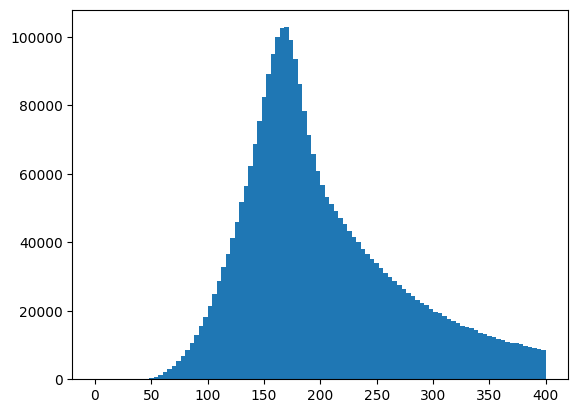

In [29]:
plt.hist(array_ttbar.to_numpy() / GeV, bins=100, range=(0, 400));